In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
from sklearn.svm import SVC

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import glob
import math

In [2]:
data07=pd.read_csv("TEDS-D-2007-DS0001-data-excel.tsv", sep='\t')
data08=pd.read_csv("TEDS-D-2008-DS0001-data-excel.tsv", sep='\t')
data09=pd.read_csv("TEDS-D-2009-DS0001-data-excel.tsv", sep='\t')
data10=pd.read_csv("TEDS-D-2010-DS0001-data-excel.tsv", sep='\t')
data11=pd.read_csv("TEDS-D-2011-DS0001-data-excel.tsv", sep='\t')
data12=pd.read_csv("TEDS-D-2012-DS0001-data-excel.csv")

In [3]:
sample07=data07.sample(n=15000)
sample08=data08.sample(n=15000)
sample09=data09.sample(n=15000)
sample10=data10.sample(n=15000)
sample11=data11.sample(n=15000)
sample12=data12.sample(n=15000)

In [4]:
frames=[sample07,sample08,sample09,sample10,sample11,sample12]
full_data=pd.concat(frames)

In [5]:
#convert age to mean age--one less dummy
age_dict={2:13, 3:16, 4:19, 5:23, 6:27, 7:32, 8:37, 9:42, 10:47, 11:52, 12:55}
def group_age(s):
    if s in age_dict.keys():
        return age_dict[s]
full_data['AGE']=full_data['AGE'].map(group_age)

#delete CASEID column
del full_data['CASEID']

#update REASON column to just 0 or 1's
#updating reason column to just 1 and 0's 
def reason_func(s):
    if s==1:
        return 1
    else:
        return 0
    #question- should those be strings or integers?
    
##replace NANs with -9
full_data=full_data.replace(np.nan, '-9')

full_data['REASON']=full_data['REASON'].map(reason_func)
full_data['REASON'].value_counts()

0    49158
1    40842
Name: REASON, dtype: int64

In [6]:
collist = full_data.columns.tolist()
collist.remove('ARRESTS')
collist.remove('DAYWAIT')
collist.remove('NOPRIOR')
collist.remove('NUMSUBS')
collist.remove('AGE')
collist.remove('LOS')
collist.remove('REASON')
cat_df = full_data[collist]

#make these numbers strings so that get dummies will work
for i in cat_df.columns:
    cat_df[i]=cat_df[i].astype(str)
cat_df.dtypes

C:\Users\yanni\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


ALCDRUG     object
ALCFLG      object
AMPHFLG     object
BARBFLG     object
BENZFLG     object
CBSA        object
COKEFLG     object
DETCRIM     object
DETNLF      object
DISYR       object
DIVISION    object
DSMCRIT     object
EDUC        object
EMPLOY      object
ETHNIC      object
FREQ1       object
FREQ2       object
FREQ3       object
FRSTUSE1    object
FRSTUSE2    object
FRSTUSE3    object
GENDER      object
HALLFLG     object
HERFLG      object
HLTHINS     object
IDU         object
INHFLG      object
LIVARAG     object
MARFLG      object
MARSTAT     object
METHFLG     object
METHUSE     object
MTHAMFLG    object
OPSYNFLG    object
OTCFLG      object
OTHERFLG    object
PCPFLG      object
PMSA        object
PREG        object
PRIMINC     object
PRIMPAY     object
PSOURCE     object
PSYPROB     object
RACE        object
REGION      object
ROUTE1      object
ROUTE2      object
ROUTE3      object
SEDHPFLG    object
SERVSETD    object
STFIPS      object
STIMFLG     object
SUB1        

In [7]:
df_with_dummies = pd.get_dummies( cat_df , prefix=cat_df.columns.tolist())
#df_with_dummies = pd.get_dummies( fake_num , prefix=fake_num.columns.tolist())

In [8]:
print "num of dummy columns", len(df_with_dummies.columns)
df_with_dummies[:2]

num of dummy columns 897


,ALCDRUG_0,ALCDRUG_1,ALCDRUG_2,ALCDRUG_3,ALCFLG_0,ALCFLG_1,AMPHFLG_0,AMPHFLG_1,BARBFLG_0,BARBFLG_1,...,SUB3_5,SUB3_6,SUB3_7,SUB3_8,SUB3_9,TRNQFLG_0,TRNQFLG_1,VET_-9,VET_1,VET_2
506800,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
547039,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [9]:
#add back the numeric columns (age, arrests, daywait, no prior, numsubs)
data=df_with_dummies
data['AGE']=full_data['AGE']
data['ARRESTS']=full_data['ARRESTS']
data['DAYWAIT']=full_data['DAYWAIT']
data['NOPRIOR']=full_data['NOPRIOR']
data['NUMSUBS']=full_data['NUMSUBS']
data['LOS']=full_data['LOS']
data['REASON']=full_data['REASON']


data.columns[400:500]

Index([u'FRSTUSE3_5', u'FRSTUSE3_6', u'FRSTUSE3_7', u'FRSTUSE3_8',
       u'FRSTUSE3_9', u'GENDER_-9', u'GENDER_1', u'GENDER_2', u'HALLFLG_0',
       u'HALLFLG_1', u'HERFLG_0', u'HERFLG_1', u'HLTHINS_-9', u'HLTHINS_1',
       u'HLTHINS_2', u'HLTHINS_3', u'HLTHINS_4', u'IDU_-8', u'IDU_-9',
       u'IDU_0', u'IDU_1', u'INHFLG_0', u'INHFLG_1', u'LIVARAG_-9',
       u'LIVARAG_1', u'LIVARAG_2', u'LIVARAG_3', u'MARFLG_0', u'MARFLG_1',
       u'MARSTAT_-9', u'MARSTAT_1', u'MARSTAT_2', u'MARSTAT_3', u'MARSTAT_4',
       u'METHFLG_0', u'METHFLG_1', u'METHUSE_-9', u'METHUSE_1', u'METHUSE_2',
       u'MTHAMFLG_0', u'MTHAMFLG_1', u'OPSYNFLG_0', u'OPSYNFLG_1', u'OTCFLG_0',
       u'OTCFLG_1', u'OTHERFLG_0', u'OTHERFLG_1', u'PCPFLG_0', u'PCPFLG_1',
       u'PMSA_-9', u'PMSA_1000', u'PMSA_1040', u'PMSA_1080', u'PMSA_1123',
       u'PMSA_1125', u'PMSA_1145', u'PMSA_1150', u'PMSA_1240', u'PMSA_1260',
       u'PMSA_1280', u'PMSA_1303', u'PMSA_1310', u'PMSA_1320', u'PMSA_1360',
       u'PMSA_1400', u'PMS

**Length of Stay** 
Problem: LOS should NOT be a dummy when predicting it... too many columns

**Reason**

In [10]:
X=data[data.columns[data.columns!='REASON']]
y=data['REASON']

#X.columns
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

In [11]:
svm = svm.SVC(gamma=0.001, C=100.)

In [12]:
svm.fit(X_train, y_train)  

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
svm.predict(X_test)
svm.score(X_test, y_test)

0.73050505050505055

In [34]:
mlp = MLPClassifier(solver='lbfgs', alpha=1, random_state=1)
mlp.fit(X_train, y_train)
mlp.predict(X_test)
mlp.score(X_test, y_test)

0.71444444444444444

In [10]:
data_new['FLG TOTAL'] = data_new['ALCFLG']+data_new['AMPHFLG']+data_new['BARBFLG']+data_new['BENZFLG']+data_new['COKEFLG']+\
data_new['HALLFLG']+data_new['HERFLG']+data_new['INHFLG']+data_new['MARFLG']+data_new['METHFLG']+data_new['MTHAMFLG']+\
data_new['OPSYNFLG']+data_new['OTCFLG']+data_new['OTHERFLG']+data_new['PCPFLG']+data_new['SEDHPFLG']+data_new['STIMFLG']

NameError: name 'data_new' is not defined

## LDA/QDA

In [38]:
llf = LDA(n_components=25)
llf.fit(X_train, y_train)
prediction_LDA=[]
prediction_LDA= llf.predict_proba(X_test)
array_LDA=[]
for i in prediction_LDA:
    array_LDA.append(i[1])
    
llf.score(X_test, y_test)

0.69999999999999996

In [26]:
qlf = QDA()
qlf.fit(X_train, y_train)
prediction_QDA=[]
prediction_QDA= qlf.predict_proba(X_test)
array_QDA=[]
for i in prediction_QDA:
    array_QDA.append(i[1])
    
qlf.score(X_test, y_test)

0.50151515151515147

In [27]:
glf = GaussianNB()
glf.fit(X_train, y_train)
prediction_GDA=[]
prediction_GDA= glf.predict_proba(X_test)
array_GDA=[]
for i in prediction_GDA:
    array_GDA.append(i[1])
glf.score(X_test, y_test)

0.53727272727272724

In [22]:
fpr_GDA, tpr_GDA, thresholds_GDA = roc_curve(y_test, array_GDA, pos_label=1)
fpr_LDA, tpr_LDA, thresholds_LDA = roc_curve(y_test, array_LDA, pos_label=1)
fpr_QDA, tpr_QDA, thresholds_QDA = roc_curve(y_test, array_QDA, pos_label=1)

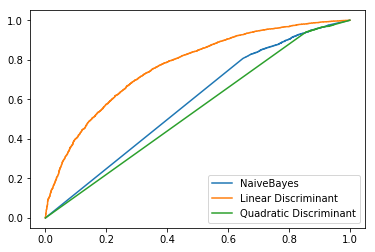

In [23]:
names  = ['NaiveBayes', 'Linear Discriminant', 'Quadratic Discriminant']
plt.plot(fpr_GDA, tpr_GDA)
plt.plot(fpr_LDA, tpr_LDA)
plt.plot(fpr_QDA, tpr_QDA)
plt.legend(names)
plt.show()

In [24]:
GDAROC = roc_auc_score(y_test, array_GDA)
LDAROC = roc_auc_score(y_test, array_LDA)
QDAROC = roc_auc_score(y_test, array_QDA)

print 'Naive Bayes ROC area under the curve is =', GDAROC
print 'Quadratic Discriminator ROC area under the curve is =', QDAROC
print 'Linear Discriminator ROC area under the curve is =', LDAROC

Naive Bayes ROC area under the curve is = 0.582811149687
Quadratic Discriminator ROC area under the curve is = 0.542141731089
Linear Discriminator ROC area under the curve is = 0.768248659012


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(learning_rate=0.3, n_estimators=175, max_depth = 7)
gbc=gbc.fit(X_train, y_train)
sc_val = gbc.score(X_test, y_test)
sc_val

0.75289562289562284

# LOS

In [22]:
los_dict={1:38, 32:53, 33:76, 34:106, 35:151, 36:273, 37:366}
#bins: 1-15, 16-30, 31-45, 46-60, 61-90, 91-120, 121-180, 181-365, 366+
data['LOS'].value_counts()

def fix_LOS(s):
    if s in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
        return 1
    if s in [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
        return 2
    else:
        return s
data['LOS']=data['LOS'].map(fix_LOS)
data['LOS'].value_counts()

1     10061
2      3751
36     3022
33     2826
35     2699
34     2392
31     2181
32     1759
37     1309
Name: LOS, dtype: int64

In [23]:
X_los=data[data.columns[data.columns!='LOS']]
y_los=data['LOS']

#X.columns
X_train_los, X_test_los, y_train_los, y_test_los = train_test_split(X_los,y_los,test_size = 0.33, random_state=42)

In [15]:
mlp = MLPClassifier(solver='lbfgs', alpha=1, random_state=1)
mlp.fit(X_train_los, y_train_los)
mlp.score(X_test_los, y_test_los)

0.41585858585858587

In [16]:
lll = LDA()
lll.fit(X_train_los, y_train_los)
lll.score(X_test_los, y_test_los)

C:\Users\yanni\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.39464646464646463

In [17]:
from sklearn.ensemble import BaggingClassifier
bg=BaggingClassifier()
bg=bg.fit(X_train_los, y_train_los)
bg.score(X_test_los, y_test_los)

0.40656565656565657

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc=rfc.fit(X_train_los, y_train_los)
sc_val = rfc.score(X_test_los, y_test_los)
sc_val

0.37878787878787878

In [23]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier()
ada=ada.fit(X_train_los, y_train_los)
sc_val = ada.score(X_test_los, y_test_los)
sc_val

0.40979797979797977

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc=gbc.fit(X_train_los, y_train_los)
sc_val = gbc.score(X_test_los, y_test_los)
sc_val

0.42747474747474745

In [15]:
from sklearn.ensemble import RandomForestClassifier
max_rf = 0
max_rfest = 0
max_rfdep=0
for i in range(5,50,5):
    for x in range(1, 15):
        rfc=RandomForestClassifier(n_estimators=i, max_depth=x)
        rfc=rfc.fit(X_train_los, y_train_los)
        sc_val = rfc.score(X_test_los, y_test_los)
        if sc_val > max_rf:
            max_rf = sc_val
            max_rfest = i
            max_rfdep = x 
print "Best score", max_rf, "Depth", max_rfdep, "Number Estimators", max_rfest

Best score 0.38898989899 Depth 14 Number Estimators 35


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
max_sc = 0
max_est = 0
max_learn=0
for i in range(25,225,25):
    for x in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        ada=AdaBoostClassifier(n_estimators=i, learning_rate=x)
        ada=ada.fit(X_train_los, y_train_los)
        sc_val = ada.score(X_test_los, y_test_los)
        if sc_val > max_sc:
            max_sc = sc_val
            max_est = i
            max_learn = x
            
print "Best score", max_sc, "Learning Rate", max_learn, "Number Estimators", max_est

Best score 0.406161616162 Learning Rate 0.7 Number Estimators 150


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
max_gsc = 0
max_gest = 0
max_glearn=0
for i in range(25,225,25):
    for x in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        gbc=GradientBoostingClassifier(n_estimators=i, learning_rate=x)
        gbc=gbc.fit(X_train_los, y_train_los)
        sc_val = gbc.score(X_test_los, y_test_los)
        if sc_val > max_gsc:
            max_gsc = sc_val
            max_gest = i
            max_glearn = x
print "Best score", max_gsc, "Learning Rate", max_glearn, "Number Estimators", max_gest

KeyboardInterrupt: 

In [ ]:
from sklearn.neural_network import MLPClassifier
max_msc = 0
max_malp = 0
max_mlearn=0
for i in range(1,1000,100):
    for x in [0.0001, 0.001,0.005,0.01,0.05,0.1,0.5,1]:
        alp = 1/i
        mlp = MLPClassifier(alpha=alp, learning_rate_init=x)
        mlp=mlp.fit(X_train_los, y_train_los)
        sc_val = mlp.score(X_test_los, y_test_los)
        if sc_val > max_msc:
            max_msc = sc_val
            max_malp = i
            max_mlearn = x
print "Best score", max_msc, "Alpha", max_malp, "Learning Rate", max_mlearn